# Homework 3

## Part 1: Imbalanced Dataset
This part of homework helps you practice to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 

### Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

Due Date : TBD

### Name: Please input your name

### UNI: Please input your UNI

## 0 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## 1 Data processing and exploration
Download the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Examine the class label imbalance
Let's look at the dataset imbalance:

**Q1. How many observations are there in this dataset? How many of them have positive label (labeled as 1)?**

In [3]:
# Your Code Here
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Total: {}\nPositive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Total: 284807
Positive: 492 (0.17% of total)



### 1.2 Clean, split and normalize the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [4]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

**Q2. Split the dataset into development and test sets. Please set test size as 0.2 and random state as 42.**

In [5]:
# Your Code Here
# Use a utility from sklearn to split the dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
test_features = np.array(test_df)

**Q3. Normalize the input features using the sklearn StandardScaler. Print the shape of your development features and test features.**

In [6]:
# Your Code Here
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (227845,)
Test labels shape: (56962,)
Training features shape: (227845, 29)
Test features shape: (56962, 29)


### 1.3 Define the model and metrics
**Q4. First, fit a default logistic regression model. Print the AUC and average precision of 5-fold cross validation.**

In [7]:
# Your Code Here
# Fit Logistic Regression model
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
scores = cross_validate(LogisticRegression(), train_df, train_labels, cv=5, 
                        scoring=['roc_auc', 'average_precision'])
print(scores['test_roc_auc'].mean(), scores['test_average_precision'].mean())
lr = LogisticRegression().fit(train_df, train_labels)

0.9739106520746865 0.7610534213016777


**Q5.1. Perform random under sampling on the development set. What is the shape of your development features? How many  positive and negative labels are there in your development set? (Please set random state as 42 when performing random under sampling)**

In [8]:
# Your Code Here
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus, = rus.fit_resample(train_df, train_labels)
print(X_rus.shape)
pd.Series(y_rus).value_counts()

(788, 29)


0    394
1    394
dtype: int64

**Q5.2. Fit a default logistic regression model using under sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random under sampling)**

In [9]:
# Your Code Here
rus = RandomUnderSampler(random_state=42)
rus_pipe = imb_make_pipeline(rus, LogisticRegression())
scores = cross_validate(rus_pipe, train_df, train_labels, cv=5, 
                        scoring=['roc_auc', 'average_precision'])
print(scores['test_roc_auc'].mean(), scores['test_average_precision'].mean())
rus_pipe.fit(train_df, train_labels)

0.9759756809709668 0.673193606310701


Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('logisticregression', LogisticRegression())])

**Q6.1. Perform random over sampling on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing random over sampling)**

In [10]:
# Your Code Here
ros = RandomOverSampler(random_state=42)
X_ros, y_ros, = ros.fit_resample(train_df, train_labels)
print(X_ros.shape)
pd.Series(y_ros).value_counts()

(454902, 29)


0    227451
1    227451
dtype: int64

**Q6.2. Fit a default logistic regression model using over sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random over sampling)**

In [11]:
# Your Code Here
ros = RandomOverSampler(random_state=42)
ros_pipe = imb_make_pipeline(ros, LogisticRegression())
scores = cross_validate(ros_pipe, train_df, train_labels, cv=5, 
                        scoring=['roc_auc', 'average_precision'])
print(scores['test_roc_auc'].mean(), scores['test_average_precision'].mean())
ros_pipe.fit(train_df, train_labels)

0.9767179748406439 0.7514657134576833


Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=42)),
                ('logisticregression', LogisticRegression())])

**Q7.1. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing SMOTE)**

In [12]:
# Your Code Here
smote = SMOTE(random_state=42)
X_smote, y_smote, = smote.fit_resample(train_df, train_labels)
print(X_smote.shape)
pd.Series(y_smote).value_counts()

(454902, 29)


0    227451
1    227451
dtype: int64

**Q7.2. Fit a default logistic regression model using SMOTE. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing SMOTE)**

In [13]:
# Your Code Here
smote = SMOTE(random_state=42)
smote_pipe = imb_make_pipeline(smote, LogisticRegression())
scores = cross_validate(smote_pipe, train_df, train_labels, cv=5, 
                        scoring=['roc_auc', 'average_precision'])
print(scores['test_roc_auc'].mean(), scores['test_average_precision'].mean())
smote_pipe.fit(train_df, train_labels)

0.9751865774132987 0.7507438898899752


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression())])

**Q8. Plot confusion matrices on the test set for all four models above. Comment on your result.**

In [14]:
# Your Code Here
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

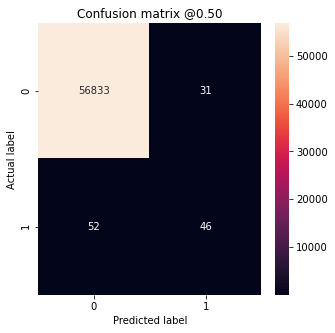

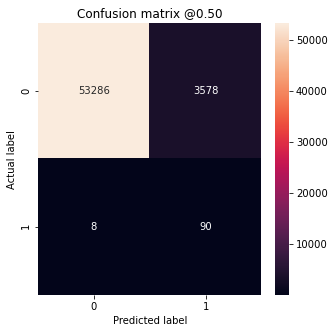

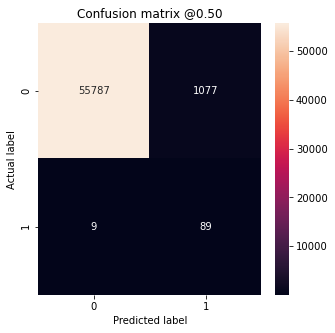

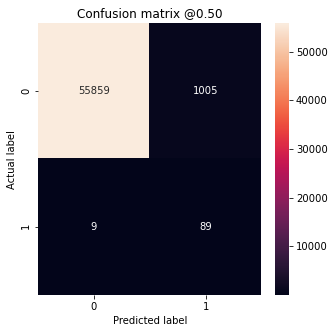

In [15]:
train_pred_lr = lr.predict(train_features)
train_pred_rus = rus_pipe.predict(train_features)
train_pred_ros = ros_pipe.predict(train_features)
train_pred_smote = smote_pipe.predict(train_features)
test_pred_lr = lr.predict(test_features)
test_pred_rus = rus_pipe.predict(test_features)
test_pred_ros = ros_pipe.predict(test_features)
test_pred_smote = smote_pipe.predict(test_features)
plot_cm(test_labels, test_pred_lr)
plot_cm(test_labels, test_pred_rus)
plot_cm(test_labels, test_pred_ros)
plot_cm(test_labels, test_pred_smote)

**Q9. Plot the ROC for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

In [16]:
# Your Code Here
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

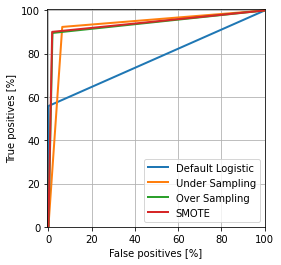

In [17]:
plot_roc("Default Logistic", train_labels, train_pred_lr)
plot_roc("Under Sampling", train_labels, train_pred_rus)
plot_roc("Over Sampling", train_labels, train_pred_ros)
plot_roc("SMOTE", train_labels, train_pred_smote)
plt.legend(loc='lower right');

**Q10. Plot the precision-recall curve for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

In [18]:
# Your Code Here
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

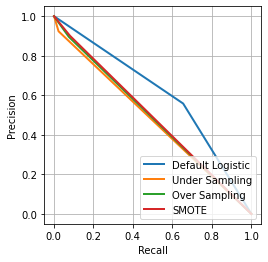

In [19]:
plot_prc("Default Logistic", train_labels, train_pred_lr)
plot_prc("Under Sampling", train_labels, train_pred_rus)
plot_prc("Over Sampling", train_labels, train_pred_ros)
plot_prc("SMOTE", train_labels, train_pred_smote)
plt.legend(loc='lower right');

**Q11. Adding class weights to a logistic regression model. Print the AUC and average precision of 5-fold cross validation. Also, plot its confusion matrix on test set.**

In [20]:
# Your Code Here
scores = cross_validate(LogisticRegression(class_weight='balanced'), train_df, train_labels, cv=5, 
                        scoring=['roc_auc', 'average_precision'])
print(scores['test_roc_auc'].mean(), scores['test_average_precision'].mean())
lr_bal = LogisticRegression(class_weight='balanced').fit(train_df, train_labels)

0.976709516908195 0.7511632001695301


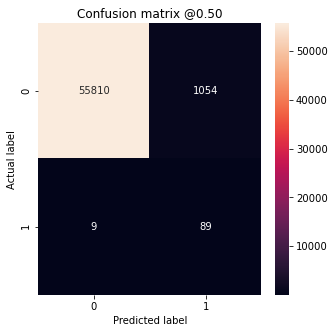

In [21]:
train_pred_lr_bal = lr_bal.predict(train_features)
test_pred_lr_bal = lr_bal.predict(test_features)
plot_cm(test_labels, test_pred_lr_bal)

**Q12. Plot the ROC and the precision-recall curve for default Logistic without any sampling method and this balanced Logistic model in two single plots. Make sure to label the axes and legend. Comment on your result.**

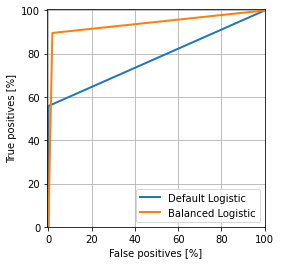

In [22]:
# Your Code Here
plot_roc("Default Logistic", train_labels, train_pred_lr)
plot_roc("Balanced Logistic", train_labels, train_pred_lr_bal)
plt.legend(loc='lower right');

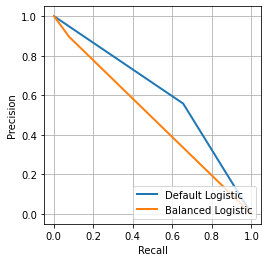

In [23]:
plot_prc("Default Logistic", train_labels, train_pred_lr)
plot_prc("Balanced Logistic", train_labels, train_pred_lr_bal)
plt.legend(loc='lower right');

## Part 2: Unsupervised Learning

In this part, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

### Dataset: single-cell RNASeq of mouse brain cells

We will be working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

Data source is on Coursework.

In [24]:
cell_gene_counts_df = pd.read_csv('data/mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [25]:
cell_metadata_df = pd.read_csv('data/mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [26]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [27]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

Our goal in this exercise is to use dimensionality reduction and clustering to visualize and better understand the high-dimensional gene expression matrix. We will use the following pipeline, which is common in single-cell analysis:
1. Use PCA to project the gene expression matrix to a lower-dimensional linear subspace.
2. Cluster the data using K-means on the first 20 principal components.
3. Use t-SNE to project the first 20 principal components onto two dimensions. Visualize the points and color by their clusters from (2).

## 1 PCA

**Q1. Perform PCA and project the gene expression matrix onto its first 50 principal components. You may use `sklearn.decomposition.PCA`.**

In [28]:
### Your code here
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cell_gene_pc = pca.fit_transform(cell_gene_counts_df)
print(cell_gene_pc.shape)

(1000, 50)


**Q2. Plot the cumulative proportion of variance explained as a function of the number of principal components. How much of the total variance in the dataset is explained by the first 20 principal components?**

Text(0, 0.5, 'Cumulative proportion of variance explained')

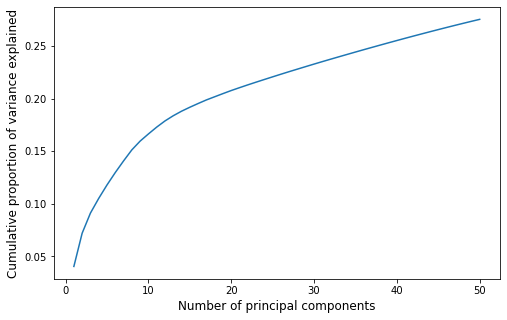

In [29]:
### Your code here

plt.figure(figsize=(8, 5))
plt.plot(range(1, 51), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of principal components', fontsize=12)
plt.ylabel('Cumulative proportion of variance explained', fontsize=12)

**Q3. For the first principal component, report the top 10 loadings (weights) and their corresponding gene names.** In other words, which 10 genes are weighted the most in the first principal component?

In [30]:
### Your code here

loadings_sort_indices = np.abs(pca.components_[0]).argsort()[::-1]
loadings_sorted = pca.components_[0][loadings_sort_indices]
loadings_sorted_gene_names = cell_gene_counts_df.columns[loadings_sort_indices]
pd.DataFrame(data=list(zip(loadings_sorted_gene_names, loadings_sorted))[:10], 
             columns=['Gene', 'PC 1 Loading'])

,Gene,PC 1 Loading
0,Nsg2,0.026673
1,St8sia3,0.026595
2,Ptpn5,0.026588
3,Kcnj4,0.026539
4,Rasgef1a,0.026347
5,Camkv,0.026221
6,Hpca,0.026173
7,Cpne5,0.026022
8,Nrsn2,0.025979
9,Erc2,0.025853


**Q4. Plot the projection of the data onto the first two principal components using a scatter plot.**

Text(0, 0.5, 'Principal component 2')

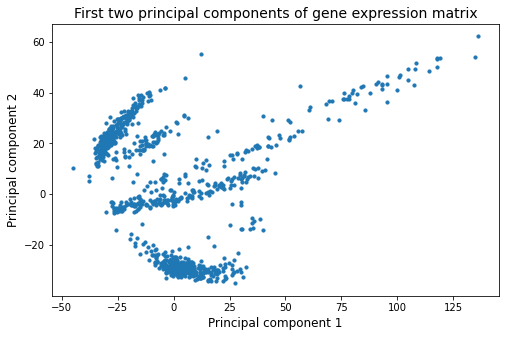

In [31]:
### Your code here

plt.figure(figsize=(8, 5))
plt.scatter(cell_gene_pc[:, 0], cell_gene_pc[:, 1], s=10)
plt.title('First two principal components of gene expression matrix', fontsize=14)
plt.xlabel('Principal component 1', fontsize=12)
plt.ylabel('Principal component 2', fontsize=12)

**Q5. Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id. Include a legend for the labels.** For example, one of the plots should have points projected onto PC 1 and PC 2, colored by their cell_ontology_class.

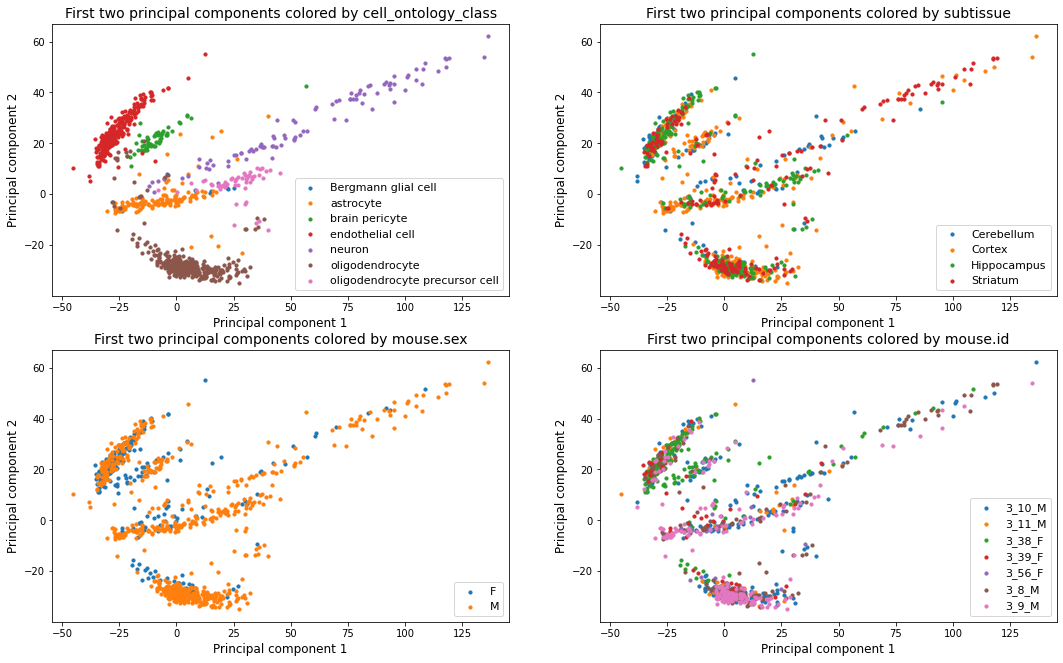

In [32]:
### Your code here

plt.figure(figsize=(18, 11))
groupby_cols = ['cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id']
for i, groupby_col in enumerate(groupby_cols):
    plt.subplot(2, 2, i+1)
    for name, group in cell_metadata_df.groupby(groupby_col):
        group_indices = group.index
        plt.scatter(cell_gene_pc[group.index, 0], cell_gene_pc[group.index, 1], 
                    s=10, label=name)
        plt.title(f'First two principal components colored by {groupby_col}', fontsize=14)
        plt.xlabel('Principal component 1', fontsize=12)
        plt.ylabel('Principal component 2', fontsize=12)
        plt.legend(fontsize=11, loc='lower right')

**Q6. Based on the plots above, the first two principal components correspond to which aspect of the cells? What is the intrinsic dimension that they are describing?**

In [33]:
### Your answer here

'''
The first two principal components are describing the cell_ontology_class, 
as those two dimensions alone separate the different cell_ontology_class 
categories quite nicely. The other annotations are not so well-separated 
by the first two principal components.
'''

'\nThe first two principal components are describing the cell_ontology_class, \nas those two dimensions alone separate the different cell_ontology_class \ncategories quite nicely. The other annotations are not so well-separated \nby the first two principal components.\n'

## 2 K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Q7. Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`. You may NOT use sklearn for this implementation. Use lecture 6, slide 14 as a reference.**

In [34]:
def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    ### Your code here
    m = X.shape[0]
    mus = X[np.random.choice(m, size=k)]
    for iter_ in range(iters):
        D = np.zeros((m, k))
        # Assign points to nearest cluster center
        for i, x_i in enumerate(X):
            for j, mu_j in enumerate(mus):
                D[i, j] = np.linalg.norm(mu_j - x_i)
        y = np.argmin(D, axis=1)
        # Re-compute cluster centers
        mus = np.array([np.mean(X[y == j], axis=0) for j in range(k)])
    return y

Before applying K-means on the gene expression data, we will test it on the following synthetic dataset to make sure that the implementation is working.

Text(0, 0.5, '$x_2$')

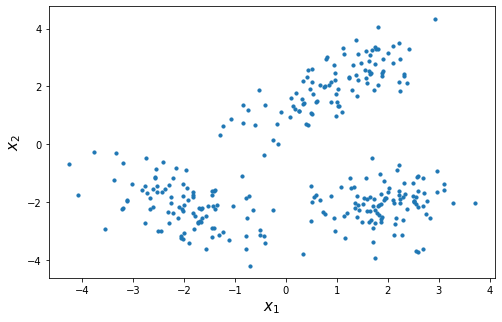

In [35]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Q8. Apply K-means with k=3 to the synthetic dataset above. Plot the points colored by their K-means cluster assignments to verify that your implementation is working.**

Text(0, 0.5, '$x_2$')

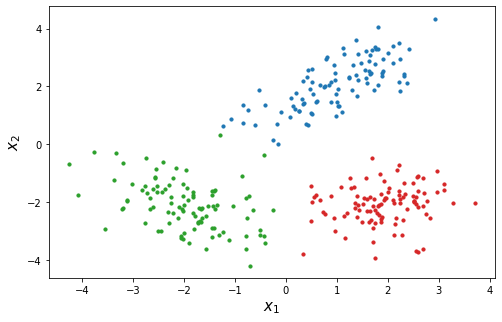

In [36]:
### Your code here

np.random.seed(0)
y = kmeans(X, 3, 10)

index_to_colors = {
    0: 'tab:green',
    1: 'tab:blue',
    2: 'tab:red'
}

plt.figure(figsize=(8, 5))
for i, x in enumerate(X):
    plt.scatter(x[0], x[1], c=index_to_colors[y[i]], s=10)
    
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Q9. Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

In [37]:
### Your code here

np.random.seed(0)
y = kmeans(cell_gene_pc[:, 0:20], 20, 10)

## 3 t-SNE

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Q10. Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. You may use `sklearn.manifold.TSNE`.** Note that it is recommended to first perform PCA before applying t-SNE to suppress noise and speed up computation.

In [38]:
### Your code here
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cell_gene_tsne = tsne.fit_transform(cell_gene_pc[:, 0:20])
print(cell_gene_tsne.shape)

(1000, 2)


**Q11. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

Text(0, 0.5, 'tSNE 2')

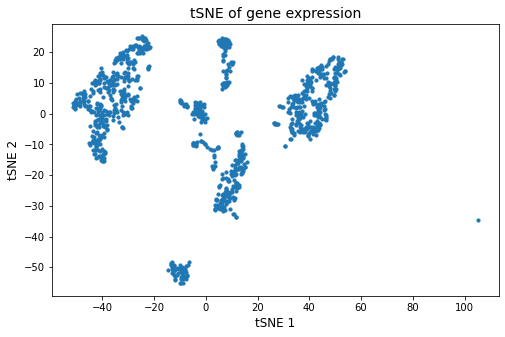

In [39]:
### Your code here

plt.figure(figsize=(8, 5))
plt.scatter(cell_gene_tsne[:, 0], cell_gene_tsne[:, 1], s=10)
plt.title('tSNE of gene expression', fontsize=14)
plt.xlabel('tSNE 1', fontsize=12)
plt.ylabel('tSNE 2', fontsize=12)

**Q12. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments from part 2.**

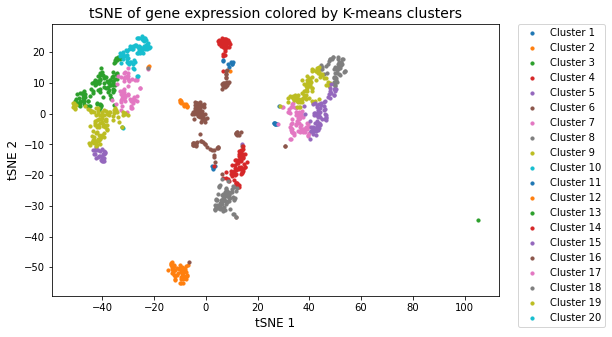

In [40]:
### Your code here

plt.figure(figsize=(8, 5))
for cluster in range(20):
    indices_in_cluster = np.where(y == cluster)
    plt.scatter(cell_gene_tsne[indices_in_cluster, 0], cell_gene_tsne[indices_in_cluster, 1], 
                s=10, label=f'Cluster {cluster+1}')
    plt.title('tSNE of gene expression colored by K-means clusters', fontsize=14)
    plt.xlabel('tSNE 1', fontsize=12)
    plt.ylabel('tSNE 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.25, 1.02), loc='upper right', ncol=1)

**Q13. Why is there overlap between points in different clusters in the t-SNE plot above?**

In [41]:
### Your answer here

'''
Because the clustering was performed in the first 20 principal
components space but is being visualized in the 2-dimensional 
t-SNE space (i.e. there is some information loss with t-SNE).
'''

'\nBecause the clustering was performed in the first 20 principal\ncomponents space but is being visualized in the 2-dimensional \nt-SNE space (i.e. there is some information loss with t-SNE).\n'

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.